William Austin<br>
Prakash Dhimal<br>
George Mason University<br>
CS 584 Theory and Applications of Data Mining<br>
Semester project: Predicting the Impact of COVID-19

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn

In [2]:
def get_raw_data():
    confirmed_df = pd.read_csv(
        'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
    recovered_df = pd.read_csv(
        'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')
    death_df = pd.read_csv(
        'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
    return confirmed_df, recovered_df, death_df


def get_country_data(data, columnName, countryName):
    country_data = data.loc[data['Country/Region'] == countryName]
    country_time_series_only = country_data.drop(["Province/State", "Country/Region", "Lat", "Long"], axis=1)
    transposed = country_time_series_only.transpose()
    transposed = pd.DataFrame({
        columnName: transposed.sum(axis=1)
    })
    return transposed


def get_country_confirmed_recovered_death_data(confirmed_df, recovered_df, death_df, countryName):
    country_confirmed = get_country_data(confirmed_df, "Confirmed", countryName)
    country_recovered = get_country_data(recovered_df, "Recovered", countryName)
    country_death = get_country_data(death_df, "Death", countryName)
    country_all = country_confirmed
    country_all["Recovered"] = country_recovered.Recovered
    country_all["Death"] = country_death.Death
    return country_all


def get_US_data(confirmed_df, recovered_df, death_df):
    us_data = get_country_confirmed_recovered_death_data(
        confirmed_df,
        recovered_df,
        death_df,
        "US")
    return us_data

In [3]:
def SEIR_model(
        y,  # SEIR at time t
        t,  # time
        N,  # the total population
        beta,  # transmission rate
        gamma,  # recovery rate
        alpha):  # exposed to infected rate (incubation rate)
    S = y[0]
    E = y[1]
    I = y[2]
    R = y[3]

    # derivative of S with respect to time
    # this is going to be negative, because the number of suspected is going to go down over time
    # The rate of change of the # of suspected people
    dSdt = - (beta * S * I) / N

    # derivative of E with respect to time
    dEdt = (beta * S * I) / N - (alpha * E)

    # derivative of I with respect to time
    dIdt = (alpha * E) - (gamma * I)

    # derivative of R with respect to time
    dRdt = gamma * I

    return dSdt, dEdt, dIdt, dRdt

In [4]:
def SEIR(
        us_only,
        N,
        n_days,
        beta,
        gamma,
        alpha,
        plot=False):
    infected_so_far = us_only.Confirmed[-1]
    death_so_far = us_only.Death[-1]
    recovered_so_far = us_only.Recovered[-1]

    # The number of infected people (so far)
    I_initial = infected_so_far

    # todo: The number of exposed at time (t)
    E_initial = infected_so_far * 3

    # removed = recovered + death (so far)
    R_initial = recovered_so_far + death_so_far

    # anyone that has not been infected, recovered, or died from COVID-19
    S_initial = N - I_initial - R_initial

    # time
    t = np.linspace(0, n_days, n_days)

    initial = S_initial, E_initial, I_initial, R_initial

    # use scipy ODE integrate function to find the solution
    solution = scipy.integrate.odeint(
        SEIR_model,
        initial,
        t,
        args=(N, beta, gamma, alpha))
    S, E, I, R = solution.T

    if plot:
        plot_SEIR(S, E, I, R, t, N, S_initial, E_initial, I_initial, R_initial, beta, gamma, alpha, n_days)

In [5]:
def plot_SEIR(S, E, I, R, t, N, S_initial, E_initial, I_initial, R_initial, beta, gamma, alpha, n_days):
    plt.figure(figsize=(10, 10))
    seaborn.lineplot(t, S / N, label="Susceptible")
    seaborn.lineplot(t, E / N, label="Exposed")
    seaborn.lineplot(t, I / N, label="Infected")
    seaborn.lineplot(t, R / N, label="Recovered + Deceased")
    plt.plot([], [], " ", label="Population: " + str(N))
    plt.plot([], [], " ", label="S_initial: " + str(S_initial))
    plt.plot([], [], " ", label="E_initial: " + str(E_initial))
    plt.plot([], [], " ", label="I_initial: " + str(I_initial))
    plt.plot([], [], " ", label="R_initial: " + str(R_initial))
    plt.plot([], [], " ", label="beta: " + str(beta))
    plt.plot([], [], " ", label="gamma: " + str(gamma))
    plt.plot([], [], " ", label="alpha: " + str(alpha))
    plt.xlabel("Time (days)")
    plt.ylabel("Fraction of Population")
    plt.title("Theoretical SEIR Model for US")
    plt.legend(loc="center right")
    plt.xticks(np.arange(0, n_days + 1, 5))
    plt.yticks(np.arange(0.0, 1.00001, 0.05))
    plt.show()

In [6]:
def model(beta, gamma, alpha, n_days, N):

    confirmed_df, recovered_df, death_df = get_raw_data()
    us_only = get_US_data(confirmed_df, recovered_df, death_df)
    SEIR(
        us_only,
        N,
        n_days,
        beta,
        gamma,
        alpha,
        plot=True)

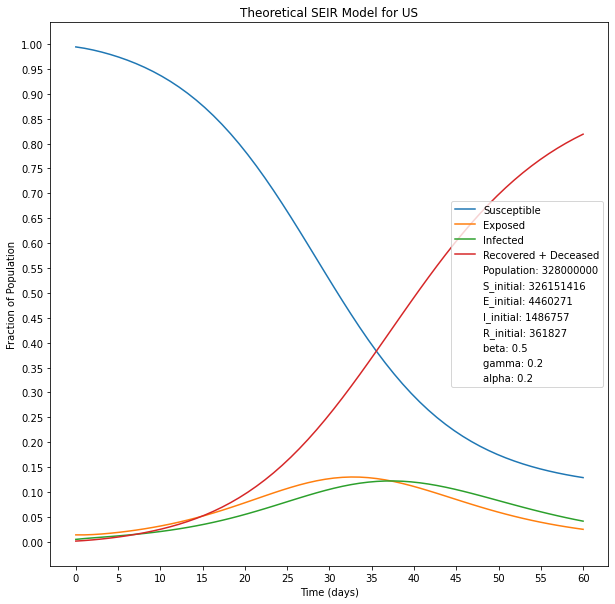

In [7]:
# we can set this later
beta = 0.5  # @param {type:"slider", min:0, max:1, step:0.1}

# check this with WHO
number_of_days_to_recover = 5  # @param {type:"slider", min:3, max:14, step:1}
gamma = 1 / number_of_days_to_recover

# CDC says 4-5 days, WHO says 5.2
Y = 5 # @param {type:"slider", min:3, max:14, step:0.2}
alpha = 1 / Y

# of days to run the model
n_days = 60  # @param {type:"slider", min:30, max:150, step:10}

# total population, Allow 300 million to 400 million
N = 328000000  # @param {type:"integer", min:3e7, max:4e8, step:1e5}
model(beta, gamma, alpha, n_days, N)